# Multihead-CNN LSTM with MP; conv filters/size grid search

We now have a reasonalby well performing model, lets do grid search of  some filter size/filter counts on the first month of data

Lets also add matrix profile data

## Load data, functions

In [16]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt
import matrixprofile as mp

In [17]:
import tensorflow.python.platform.build_info as build
print(build.build_info)

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.27.29110/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [18]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [19]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [20]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [21]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [22]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [23]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [24]:
def generate_training_val_examples(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))

    
    return X_train, y_train, X_val, y_val, scaler



In [25]:
def LSTM_model():
    
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(n_steps_in, len(inputs))))
    model.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='tanh')))
    model.add(TimeDistributed(Dense(len(inputs))))
    model.compile(loss='mse', optimizer='adam')
    return model, model_checkpoint_callback

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [27]:
def descale_y_retrun_metrics(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for each output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [28]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler

In [29]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for single output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    for j in range(0, n_steps_out):
        pred_descaled= (scaler.inverse_transform(yhat[:, j:j+1, :len(inputs)].reshape(yhat.shape[0], len(inputs))))[:,:1]
        groud_truth_descaled= (scaler.inverse_transform(array([y_val2[ :, j:j+1,0].reshape(y_val2.shape[0])]*len(inputs)).transpose()))[:,:1]
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

## Matrix Profile

In [30]:
def add_mp(data, window):
    #Given 3d array, add matrix profile of (x,y,0) as new dimension; new array has dimensiosn (x,y,z+1) 
    mp_list=[]
    for i in data[:,:,0]:
        profile = mp.compute(i, window, n_jobs=4)['mp']
        #we are padding the end of the sequence with the mean
        #matrix profile is always 1 full window size smalelr than input data
        mp_list.append(np.append(profile,([mean(profile)]*(data.shape[1]-len(profile)))))
        
    #concatenate matrix profile data with original    
    mp_array = np.array(mp_list).reshape(data.shape[0], data.shape[1])
    std_array = ((mp_array-mean(mp_array))/np.std(mp_array)).reshape(data.shape[0], data.shape[1],1)
    data = np.concatenate((data, std_array), axis=2)
    
    return data

In [40]:
def LSTM_model():
    #set up callback for best val loss model
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    input_layer = Input(shape=(n_steps_in, X_train.shape[2])) 
    head_list = []
    for i in range(0, X_train.shape[2]):
        conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
        conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
        conv_layer_flatten = Flatten()(conv_layer_head_2)
        head_list.append(conv_layer_flatten)

    concat_cnn = Concatenate(axis=1)(head_list)
    reshape = Reshape((head_list[0].shape[1], X_train.shape[2]))(concat_cnn)
    lstm = LSTM(100, activation='tanh')(reshape)
    repeat = RepeatVector(n_steps_out)(lstm)
    lstm_2 = (Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))(repeat)
    dropout = Dropout(0.2)(lstm_2)
    dense = Dense(X_train.shape[2], activation='linear')(dropout)
    model = Model(inputs=input_layer, outputs=dense)
    model.compile(loss='mse', optimizer='adam')
    return model, model_checkpoint_callback


In [ ]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288


y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp(X_train, mp_window)
    X_val = add_mp(X_val, mp_window)
    

    
    
    model, model_checkpoint_callback = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.save(('mp_cnn/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)
    
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
    keras.backend.clear_session()

pd.DataFrame(train_loss_list).to_csv('mp_cnn/train_loss')
pd.DataFrame(val_loss_list).to_csv('mp_cnn/val_loss')

In [231]:
training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
keras.backend.clear_session()

In [232]:
#ran for 1 month
training_metrics_dicts

[        RMSE          MSE        MAE      MAPE        R2
 1  27.415203   751.593373  11.870543  0.154866  0.695554
 2  29.330367   860.270456  12.985660  0.160425  0.651545
 3  33.299560  1108.860699  14.125820  0.170865  0.550843
 4  31.893510  1017.195959  14.350097  0.174247  0.587910
 5  35.836557  1284.258848  14.969885  0.183745  0.479723]

In [233]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  20.562764  422.827276  12.083029  0.169372  0.260292
 2  20.046172  401.849027  12.924464  0.176793  0.296787
 3  20.289057  411.645851  13.585540  0.185970  0.279683
 4  20.792651  432.334350  13.799172  0.190772  0.244173
 5  22.037205  485.638391  14.040134  0.198531  0.151106]

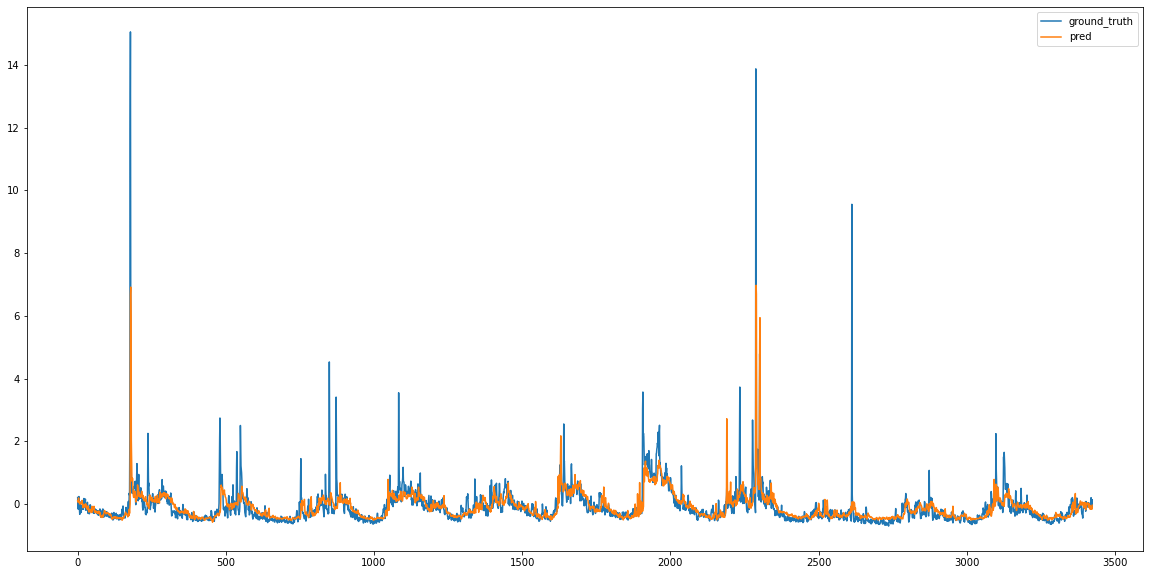

In [235]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_train[:,4:5,:1].flatten(),label='ground_truth')
plt.plot(yhat_train[:,4:5,:1].flatten(), label='pred')
plt.legend()

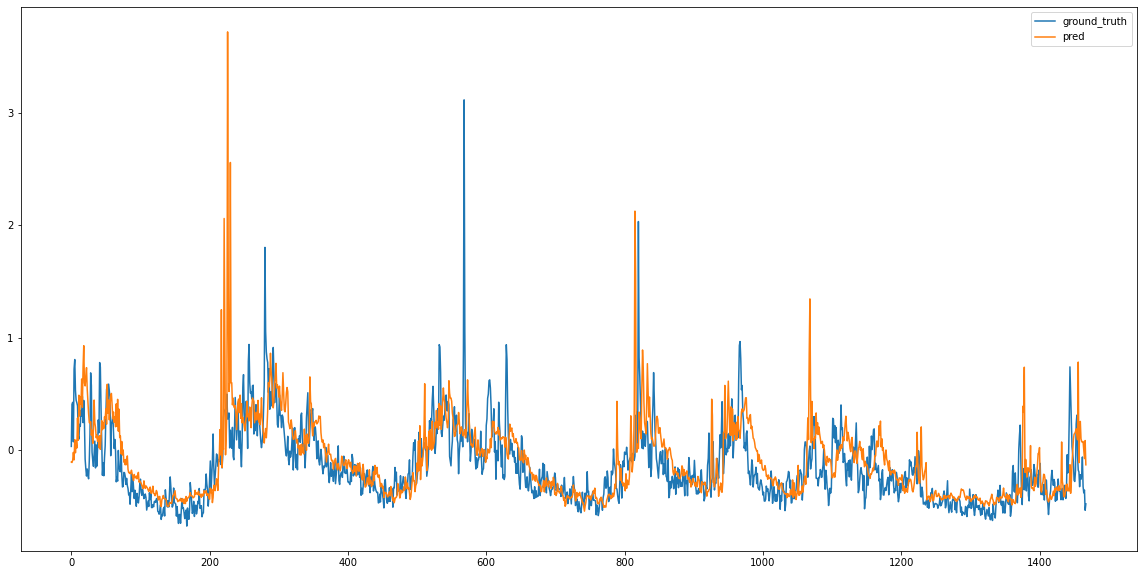

In [245]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(y_val[:,4:5,:1].flatten(), label='ground_truth')
plt.plot(yhat_val[:,4:5,:1].flatten(), label='pred')
plt.legend()

## Lets test different filter sizes on the firsth month of data

In [50]:
def LSTM_model(filters, kernel_size):
    checkpoint_filepath='./cnn/'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    input_layer = Input(shape=(n_steps_in, X_train.shape[2])) 
    head_list = []
    for i in range(0, X_train.shape[2]):
        conv_layer_head = Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh')(input_layer)
        conv_layer_head_2 = Conv1D(filters=filters, kernel_size=kernel_size, activation='tanh')(conv_layer_head)
        conv_layer_flatten = Flatten()(conv_layer_head_2)
        head_list.append(conv_layer_flatten)

    concat_cnn = Concatenate(axis=1)(head_list)
    reshape = Reshape((head_list[0].shape[1], X_train.shape[2]))(concat_cnn)
    lstm = LSTM(100, activation='tanh')(reshape)
    repeat = RepeatVector(n_steps_out)(lstm)
    lstm_2 = (Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))(repeat)
    dropout = Dropout(0.2)(lstm_2)
    dense = Dense(X_train.shape[2], activation='linear')(dropout)
    model = Model(inputs=input_layer, outputs=dense)
    model.compile(loss='mse', optimizer='adam')
    return model, model_checkpoint_callback, checkpoint_filepath

In [15]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288


y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
parameter_index=[]
month=0
for filters in [3,6,9,12,15]:
    for kernel_size in [3,5,7,9,11,13,15]:
        n_step_lookahead = 1
        start_date=Start_dates[month]
        end_date=end_dates[month]
        X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
        X_train = add_mp(X_train, mp_window)
        X_val = add_mp(X_val, mp_window)




        model, model_checkpoint_callback = LSTM_model(filters, kernel_size)
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        

        yhat_train=model.predict(X_train, verbose=1)
        yhat_val = model.predict(X_val, verbose=1)

        training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
        valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
        np.save("mp_cnn_2/training_metrics.npy", training_metrics_dicts)
        np.save("mp_cnn_2/val_metrics.npy", valdiation_metrics_dicts)
        
        parameter_index.append([filters, kernel_size])
        
        keras.backend.clear_session()

        pd.DataFrame(train_loss_list).to_csv('mp_cnn_2/train_loss')
        pd.DataFrame(val_loss_list).to_csv('mp_cnn_2/val_loss')
        

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\conal\AppData\Local\Temp/ipykernel_21480/2876182329.py", line 30, in <module>
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
  File "C:\Users\conal\AppData\Local\Temp/ipykernel_21480/3645274405.py", line 5, in generate_training_val_examples_univariate_output
    scaler = StandardScaler()
NameError: name 'StandardScaler' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent

TypeError: object of type 'NoneType' has no len()

In [252]:
np.save("mp_cnn_2/training_metrics.npy", training_metrics_dicts)
np.save("mp_cnn_2/val_metrics.npy", valdiation_metrics_dicts)
        
parameter_index.append([filters, kernel_size])
        
keras.backend.clear_session()

pd.DataFrame(train_loss_list).to_csv('mp_cnn_2/train_loss')
pd.DataFrame(val_loss_list).to_csv('mp_cnn_2/val_loss')

## check point was not set up corretly; lowest validation loss was achieved after 4 epochs with 9 filter 7 kernel size model, lets train this again with callbacks corretly sety up

In [ ]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 5
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288


y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
parameter_index=[]
month=0
for filters in [9]:
    for kernel_size in [7]:
            for month in [0, 1, 2, 3, 4]:
                n_step_lookahead = 1
                start_date=Start_dates[month]
                end_date=end_dates[month]
                X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
                X_train = add_mp(X_train, mp_window)
                X_val = add_mp(X_val, mp_window)




                model, model_checkpoint_callback, checkpoint_filepath = LSTM_model(filters, kernel_size)
                train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
                train_loss_list.append(train_history.history['loss'])
                val_loss_list.append(train_history.history['val_loss'])

                model.load_weights(checkpoint_filepath)
                yhat_train=model.predict(X_train, verbose=1)
                yhat_val = model.predict(X_val, verbose=1)
                model.save('mp_cnn_best/' +str(month)+'/')

                training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
                valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))
                np.save("mp_cnn_best/training_metrics.npy", training_metrics_dicts)
                np.save("mp_cnn_best/val_metrics.npy", valdiation_metrics_dicts)

                parameter_index.append([filters, kernel_size])

                keras.backend.clear_session()

                pd.DataFrame(train_loss_list).to_csv('mp_cnn_best/train_loss')
                pd.DataFrame(val_loss_list).to_csv('mp_cnn_best/val_loss')

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - ETA: 0s - loss: 0.3734

INFO:tensorflow:Assets written to: ./cnn_best\assets


INFO:tensorflow:Assets written to: ./cnn_best\assets


107/107 [==============================] - 171s 2s/step - loss: 0.3734 - val_loss: 0.0610
Epoch 2/15
107/107 [==============================] - 125s 1s/step - loss: 0.3346 - val_loss: 0.0621
Epoch 3/15
107/107 [==============================] - ETA: 0s - loss: 0.3233

INFO:tensorflow:Assets written to: ./cnn_best\assets


INFO:tensorflow:Assets written to: ./cnn_best\assets


107/107 [==============================] - 164s 2s/step - loss: 0.3233 - val_loss: 0.0543
Epoch 4/15
107/107 [==============================] - ETA: 0s - loss: 0.3154

INFO:tensorflow:Assets written to: ./cnn_best\assets


INFO:tensorflow:Assets written to: ./cnn_best\assets


107/107 [==============================] - 165s 2s/step - loss: 0.3154 - val_loss: 0.0518
Epoch 5/15
107/107 [==============================] - ETA: 0s - loss: 0.3067

INFO:tensorflow:Assets written to: ./cnn_best\assets


INFO:tensorflow:Assets written to: ./cnn_best\assets


107/107 [==============================] - 161s 2s/step - loss: 0.3067 - val_loss: 0.0508
Epoch 6/15
107/107 [==============================] - 120s 1s/step - loss: 0.2935 - val_loss: 0.0639
Epoch 7/15
107/107 [==============================] - 119s 1s/step - loss: 0.2827 - val_loss: 0.0537
Epoch 8/15
107/107 [==============================] - 119s 1s/step - loss: 0.2727 - val_loss: 0.0590
Epoch 9/15
107/107 [==============================] - 119s 1s/step - loss: 0.2672 - val_loss: 0.0927
Epoch 10/15
107/107 [==============================] - 119s 1s/step - loss: 0.3077 - val_loss: 0.0533
Epoch 11/15
107/107 [==============================] - 174s 2s/step - loss: 0.2644 - val_loss: 0.0733
Epoch 12/15
107/107 [==============================] - 128s 1s/step - loss: 0.2385 - val_loss: 0.0814
Epoch 13/15
107/107 [==============================] - 124s 1s/step - loss: 0.2140 - val_loss: 0.0659
Epoch 14/15
107/107 [==============================] - 125s 1s/step - loss: 0.2201 - val_loss: 0.1